In [ ]:

!pip install tensorflow pillow numpy
!pip install rembg
!pip install rembg onnxruntime
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import io
import base64
from IPython.display import HTML, display
from google.colab.output import eval_js


np.set_printoptions(suppress=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


In [ ]:

from google.colab import files
uploaded = files.upload()  # Upload keras_Model.h5 and labels.txt

In [ ]:

model = load_model("/content/keras_model.h5", compile=False)


class_names = open("/content/labels.txt", "r").readlines()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


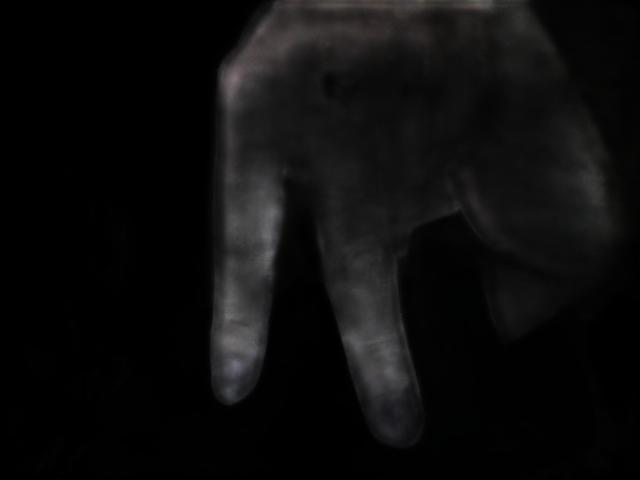

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class: N
Confidence Score: 0.82908654


In [ ]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import io
import base64
from IPython.display import HTML, display, Image as IPImage
from google.colab.output import eval_js
from rembg import remove
from tensorflow.keras.layers import DepthwiseConv2D

np.set_printoptions(suppress=True)

# Tùy chỉnh DepthwiseConv2D nếu có
class CustomDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

# Load mô hình
model = load_model("/content/keras_model.h5", custom_objects={'DepthwiseConv2D': CustomDepthwiseConv2D}, compile=False)

# Load class names
class_names = open("/content/labels.txt", "r").readlines()

# Hàm chụp ảnh từ webcam
def capture_webcam_image():
    js = """
    async function captureImage() {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture Image';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.transform = 'scaleX(-1)';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return canvas.toDataURL('image/jpeg', 0.8);
    }
    """
    display(HTML('<script>' + js + '</script>'))
    data_url = eval_js('captureImage()')
    return data_url

# Chụp ảnh
data_url = capture_webcam_image()
img_data = base64.b64decode(data_url.split(',')[1])
image = Image.open(io.BytesIO(img_data)).convert("RGBA")

# Tách nền
image_no_bg = remove(image)

# Chuyển sang RGB (bỏ alpha sau khi tách nền)
image_no_bg = image_no_bg.convert("RGB")

# Hiển thị ảnh đã tách nền
img_buffer = io.BytesIO()
image_no_bg.save(img_buffer, format="JPEG")
display(IPImage(data=img_buffer.getvalue()))

# Chuẩn bị ảnh cho mô hình
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
size = (224, 224)
image_resized = ImageOps.fit(image_no_bg, size, Image.Resampling.LANCZOS)
image_array = np.asarray(image_resized)
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
data[0] = normalized_image_array

# Dự đoán
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

print("Class:", class_name[2:].strip())
print("Confidence Score:", confidence_score)
